<h1 align="center">Facial Recognition.</h1>

    Marci Hepner
    11/27/2018

In [34]:
# Import libraries
import os
import numpy as np
import numpy.linalg as la
from imageio import imread
import matplotlib.pyplot as plt
import os

os.system('jupyter nbconvert --to html facial_recognition.ipynb')


SyntaxError: invalid syntax (<ipython-input-34-e1ded9fbac0e>, line 10)

### Helper Functions

In [24]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray = True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Using show() to Show a Random Face

In [25]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    
    image = image.reshape((m,n)) #reshape to look like an image
    plt.imshow(image, cmap='gray')
    plt.show()

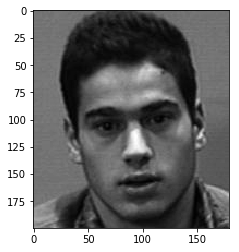

In [26]:
# Generate matrix 'F' - database of 153 faces
F = get_faces()

f = F[:,np.random.randint(0, 153)] # Pick a random face to display

show(f) # Implement show() to reshape and display face

In [27]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces(path)
        self.mu = np.mean(self.F, axis=1)
        # Broadcast subtraction over the COLUMNS.
        
        self.Fbar = self.F - np.vstack(self.mu)
        
        self.U,v,d = la.svd(self.Fbar, full_matrices=False) #find the SVD

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        #find the F_hat and G_hat values
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(g-self.mu, s)
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        
        j = self.find_nearest(image, s) #find the match
        match = self.F[:,j]

        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n) #show the match
        
        plt.show()

### "Mean" Faces

- In this section, I show the mean face of all of the faces in the database. Then, I show the original face and the mean shifted face for comparion. 

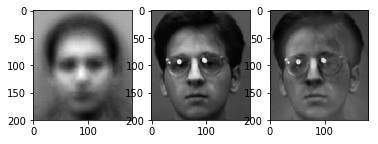

In [28]:
Faces = FacialRec()

#make a random face
random_Face = Faces.F[:,np.random.randint(153)]

#Plot the mean face
plt.subplot(131)
plt.imshow(Faces.mu.reshape(200,180), cmap='gray')

#Plot the original face
plt.subplot(132)
plt.imshow(random_Face.reshape(200,180), cmap='gray')

#Plot the mean shifted face
plt.subplot(133)
plt.imshow(random_Face.reshape(200,180) - Faces.mu.reshape(200,180), cmap = 'gray')

plt.show()

### Projections

- To show how the U value in the SVD impacts the amount of detail in each image, I have shown reconstructions


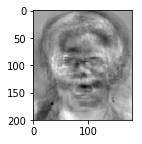

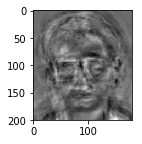

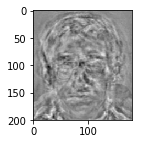

In [29]:
#plot various projection faces
plt.subplot(131)
show(Faces.U[:,20])
plt.subplot(132)
show(Faces.U[:,50])
plt.subplot(133)
show(Faces.U[:,100])


### Project and Reconstruct

- I take a shifted image and show the steps in reconstruction


2


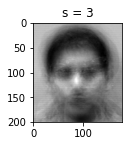

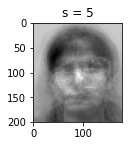

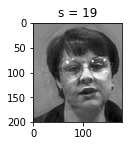

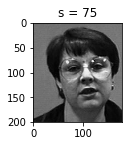

In [30]:
image = Faces.Fbar[:,0]

#values of s to iterate over
s_vals = [3,5,19,75]

#rows and columns for subplots
numcols = len(s_vals)//2
numrows = numcols
print(numrows)
for i in range(len(s_vals)):
    plt.subplot(numrows, numcols, i+1)
    plt.title("s = " + str(s_vals[i]))
    #get the weights
    projection = Faces.project(image, s_vals[i])
    #Reconstruct the original images by multiplying the projection by the basis vector up to s and adding the mean face
    reconstruction = Faces.U[:,:s_vals[i]] @ projection + Faces.mu
    show(reconstruction)

### Find Nearest
Implement `FacialRec.find_nearest()`.

In [31]:
#find the index of the person who is closest to the random face
Faces.find_nearest(random_Face)

44

### Find the Match

- Here I generate random sample faces and I find the perfect match

In [32]:
def sample_faces(num_faces, path="./faces94"): # Get the list of possible images. 
    files = [] 
    for (dirpath, dirnames, filenames) in os.walk(path): 
        for fname in filenames: 
            if fname[-3:]=="jpg": # Only get jpg images. 
                files.append(dirpath+"/"+fname)
# Get a subset of the image names and yield the images one at a time. 
    test_files = np.random.choice(files, num_faces, replace=False) 
    for fname in test_files: 
        yield np.ravel(imread(fname, as_gray=True))

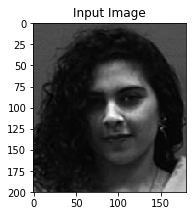

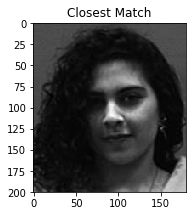

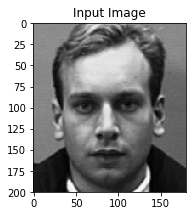

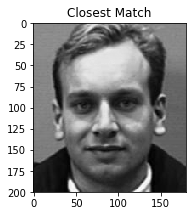

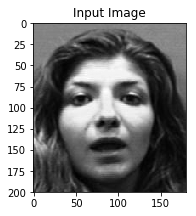

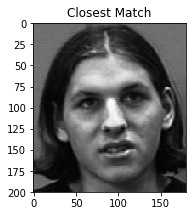

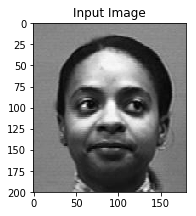

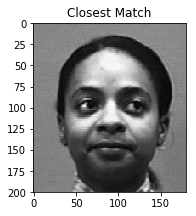

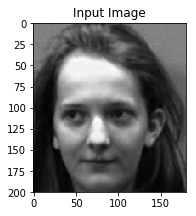

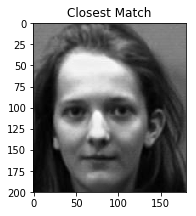

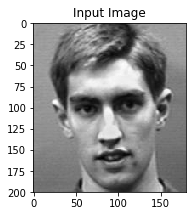

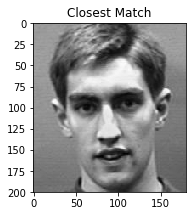

In [33]:
for test_image in sample_faces(6):
    #find the matched faces
    matchedFaces = Faces.match(test_image)
